<a href="https://colab.research.google.com/github/tommykil123/MultiClassification/blob/master/Rock_Paper_Scissor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

# Rock Paper Scissor Example

In [0]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip \
    -O /tmp/rps.zip
  
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip \
    -O /tmp/rps-test-set.zip

--2019-07-02 12:51:09--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.161.48, 2404:6800:4004:80f::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.161.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 200682221 (191M) [application/zip]
Saving to: ‘/tmp/rps.zip’

/tmp/rps.zip        100%[===================>] 191.38M   103MB/s    in 1.9s    

2019-07-02 12:51:11 (103 MB/s) - ‘/tmp/rps.zip’ saved [200682221/200682221]

--2019-07-02 12:51:12--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.161.48, 2404:6800:4004:80f::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.161.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29516758 (28M) [application/zip]
Saving to: ‘/tmp/rps-test-set.zip’

/t

## Extracting Images from Zip

In [0]:
import os
import zipfile

local_zip = '/tmp/rps.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

local_zip = '/tmp/rps-test-set.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

### Dataset

In [0]:
rock_dir = os.path.join('/tmp/rps/rock')
paper_dir = os.path.join('/tmp/rps/paper')
scissors_dir = os.path.join('/tmp/rps/scissors')

print('total training rock images:', len(os.listdir(rock_dir)))
print('total training paper images:', len(os.listdir(paper_dir)))
print('total training scissors images:', len(os.listdir(scissors_dir)))

rock_files = os.listdir(rock_dir)
print(rock_files[:10])

paper_files = os.listdir(paper_dir)
print(paper_files[:10])

scissors_files = os.listdir(scissors_dir)
print(scissors_files[:10])

total training rock images: 840
total training paper images: 840
total training scissors images: 840
['rock07-k03-063.png', 'rock07-k03-046.png', 'rock06ck02-101.png', 'rock05ck01-051.png', 'rock06ck02-025.png', 'rock03-076.png', 'rock07-k03-058.png', 'rock03-039.png', 'rock04-112.png', 'rock04-019.png']
['paper05-022.png', 'paper07-090.png', 'paper07-089.png', 'paper04-115.png', 'paper07-018.png', 'paper04-066.png', 'paper02-053.png', 'paper06-052.png', 'paper07-102.png', 'paper03-063.png']
['scissors01-025.png', 'scissors02-079.png', 'scissors01-001.png', 'scissors01-070.png', 'scissors04-049.png', 'testscissors01-060.png', 'scissors03-100.png', 'testscissors03-076.png', 'scissors02-035.png', 'scissors03-069.png']


### Display the images

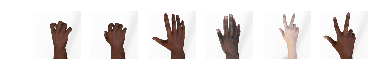

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic_index = 2

next_rock = [os.path.join(rock_dir, fname) 
                for fname in rock_files[pic_index-2:pic_index]]
next_paper = [os.path.join(paper_dir, fname) 
                for fname in paper_files[pic_index-2:pic_index]]
next_scissors = [os.path.join(scissors_dir, fname) 
                for fname in scissors_files[pic_index-2:pic_index]]


for i, img_path in enumerate(next_rock+next_paper+next_scissors):
  #print(img_path)
  sp = plt.subplot(1,6, i + 1)
  sp.axis('Off')
  img = mpimg.imread(img_path)
  plt.imshow(img)
  
plt.show()

## Generators

In [0]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

TRAINING_DIR = "/tmp/rps/"
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	  rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

VALIDATION_DIR = "/tmp/rps-test-set/"
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(150,150),
	class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(150,150),
	class_mode='categorical'
)


Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


## Training Models

In [0]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

W0702 13:33:08.813386 140551495231360 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### Summary

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

### Compile and Run the Model

In [0]:
model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history = model.fit_generator(train_generator, epochs=25, validation_data = validation_generator, verbose = 1)

model.save("rps.h5")

Epoch 1/25
79/79 [==============================] - 24s 299ms/step - loss: 1.1876 - acc: 0.3655 - val_loss: 0.9199 - val_acc: 0.4973
Epoch 2/25
79/79 [==============================] - 20s 258ms/step - loss: 0.8603 - acc: 0.5833 - val_loss: 0.4729 - val_acc: 0.8172
Epoch 3/25
79/79 [==============================] - 20s 258ms/step - loss: 0.5588 - acc: 0.7615 - val_loss: 0.1959 - val_acc: 0.9543
Epoch 4/25
79/79 [==============================] - 20s 256ms/step - loss: 0.3723 - acc: 0.8500 - val_loss: 0.2346 - val_acc: 0.9005
Epoch 5/25
79/79 [==============================] - 20s 254ms/step - loss: 0.2591 - acc: 0.9123 - val_loss: 0.1240 - val_acc: 0.9543
Epoch 6/25
79/79 [==============================] - 20s 255ms/step - loss: 0.2817 - acc: 0.9000 - val_loss: 0.0628 - val_acc: 0.9812
Epoch 7/25
79/79 [==============================] - 20s 258ms/step - loss: 0.2140 - acc: 0.9274 - val_loss: 0.0724 - val_acc: 0.9731
Epoch 8/25
79/79 [==============================] - 20s 255ms/step - 

### Plot Training vs Validation Accuracy

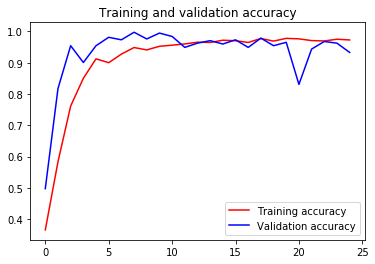

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

## Test Model from Images from the Web

In [0]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(fn)
  print(classes)

Using TensorFlow backend.


# MNIST
### Handwritten Digits

In [0]:
from keras.datasets import mnist
import numpy as np
(x_train, y_train), (x_test, y_test) = mnist.load_data()

## Data

### Display the images

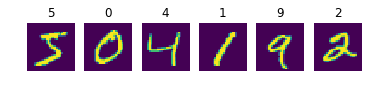

In [24]:
%matplotlib inline

from google.colab.patches import cv2_imshow
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for i in range(0,6):
  #print(img_path)
  sp = plt.subplot(1,6, i + 1)
  sp.axis('Off')
  plt.imshow(x_train[i])
  sp.set_title(y_train[i])
plt.show()

### Histogram Plot

Text(0.5, 1.0, 'Testing Data')

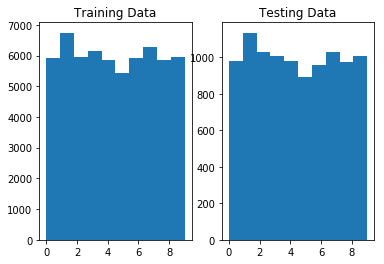

In [44]:
sp1 = plt.subplot(1,2,1)
plt.hist(y_train)
sp1.set_title('Training Data')
sp2 = plt.subplot(1,2,2)
plt.hist(y_test)
sp2.set_title('Testing Data')

## PreProcess

In [0]:
x_train = x_train / 255.0
x_test = x_test / 255.0

## Training Models

In [0]:
import tensorflow as tf
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(28, 28,1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

### Summary

In [49]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 10816)             0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 10816)             0         
_________________________________________________________________
dense_24 (Dense)             (None, 128)               1384576   
_________________________________________________________________
dense_25 (Dense)             (None, 10)                1290      
Total params: 1,386,506
Trainable params: 1,386,506
Non-trainable params: 0
___________________________________________

### Compile and Run Model

In [50]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

x_train4 = x_train.reshape(-1,28, 28, 1) 
x_test4 = x_test.reshape(-1,28, 28, 1)
# history = model.fit(x = x_train, y = y_train, epochs=25, validation_data = (x_test, y_test), verbose = 1)
history = model.fit(x = x_train4, y = y_train, epochs=25, validation_data = (x_test4, y_test))
model.save("mnist.h5")

Train on 60000 samples, validate on 10000 samples
Epoch 1/25
 6304/60000 [==>...........................] - ETA: 1:19 - loss: 0.4727 - acc: 0.8553

KeyboardInterrupt: ignored

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [40]:
temp = x_train.reshape(-1,28, 28, 1)
print(temp.shape)
print(x_train.shape)

(60000, 28, 28, 1)
(60000, 28, 28)


# Cifar-10 
### Airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

In [0]:
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Fashion MNIST
### Fashion Clothing Articles


In [0]:
from keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()